# Face recognition (using MTCNN) and tracking in video 

Important links, code is inspired from:
- original url: https://github.com/vudung45/FaceRec
- models (need to download): https://github.com/davidsandberg/facenet
- MTCNN Face Detection: https://kpzhang93.github.io/MTCNN_face_detection_alignment/
- Augmentation code: https://github.com/vxy10/ImageAugmentation
- Fancy borders: https://www.codemade.io/fast-and-accurate-face-tracking-in-live-video-with-python/

Facenet:
- example network is based the work done by David Sandberg here: 
- https://github.com/davidsandberg/facenet
Facenet is not a classifier that is trained to classify a face as 
belonging to a particular individual that it was trained on. Instead it is trained to find and quantify 
landmarks on faces in general. By comparing the face landmark quantification values (network inference output) 
on two images, it is possible to determine how likely the two faces are of the same person.

Face tracking using dlib:
- https://www.guidodiepen.nl/2017/02/detecting-and-tracking-a-face-with-python-and-opencv/
- https://www.guidodiepen.nl/2017/02/tracking-multiple-faces/
- https://github.com/gdiepen/face-recognition
Face tracking using opencv:
- https://www.learnopencv.com/object-tracking-using-opencv-cpp-python/

More intersting links:
- https://github.com/yobibyte/yobiface
- https://github.com/ageitgey/face_recognition
- https://github.com/shaoanlu/faceswap-GAN

## Instructions
- Download models
- Collect images of persons that appear in your video. Put them in the images folder
- Get a video (for example https://www.youtube.com/watch?v=NuhCoO6GO5U). Put it in the videos folder
- Change name of video in code and run
- Output should be similar to: https://drive.google.com/file/d/1URUCyngQ1lsZvKu3up2Vdnuc8172WXYb/view?usp=sharing

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
%cd '/gdrive/MyDrive/Colab Notebooks/facerec/'
! ls -ashl

/gdrive/MyDrive/Colab Notebooks/facerec
total 392K
5.5K -rw------- 1 root root 5.1K Jan 16 21:24 align_custom.py
4.0K drwx------ 2 root root 4.0K Jan 16 21:13 architecture
2.0K -rw------- 1 root root 1.9K Jan 16 21:51 face_feature.py
 66K -rw------- 1 root root  66K Jan  3  2019 facerec_128D_got.txt
 34K -rw------- 1 root root  34K Jan 17 20:09 facerec_128D_scalable.txt
 83K -rw------- 1 root root  83K Jan 17 20:09 facerec_128D.txt
 30K -rw------- 1 root root  30K Jan 16 22:30 face_rec_track.jpg
118K -rw------- 1 root root 118K Jan 27 21:06 face_track_recognition.ipynb
4.0K drwx------ 2 root root 4.0K Jan 16 21:13 images
 12K -rw------- 1 root root  12K Jan 16 21:44 inception_resnet_v1.py
4.0K drwx------ 2 root root 4.0K Jan 16 21:14 models
 22K -rw------- 1 root root  22K Jan 16 21:56 mtcnn_detect.py
4.0K drwx------ 2 root root 4.0K Jan 16 21:29 __pycache__
 512 -rw------- 1 root root  338 Jan 16 21:53 tf_graph.py
4.0K drwx------ 2 root root 4.0K Jan 16 21:16 videos


## Snapshot from an example output video

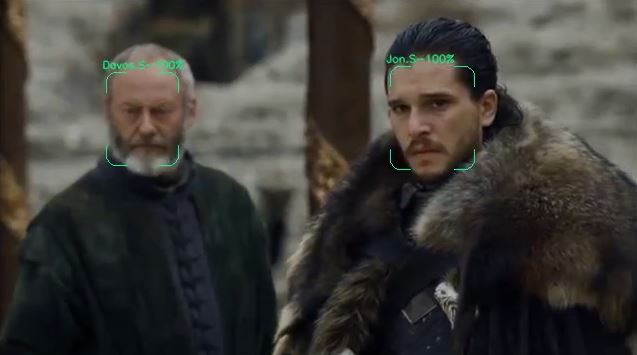

In [3]:
from IPython.display import Image
Image(filename='face_rec_track.jpg',width=1000)

# Installs and Imports

In [4]:
#! pip install tf-slim
#! pip install numpy==1.16.2

In [5]:
import os, sys, glob
import cv2
import dlib
from align_custom import AlignCustom
from face_feature import FaceFeature
from mtcnn_detect import MTCNNDetect
from tf_graph import FaceRecGraph
import argparse
import sys
import json
import numpy as np
from sklearn.cluster import KMeans
import time

import scipy
import scipy.io as sio
from scipy.io import loadmat
from datetime import datetime
import pandas as pd


Instructions for updating:
non-resource variables are not supported in the long term


# Functions

## Database Functions

In [13]:
def import_from_images():
    print()
    print("[INFO] Extracting data from images ...")
    img_folder = "images/"
    dict_img_files = dict()
    #os.chdir(+img_folder)
    img_dir = glob.glob(img_folder+"*")
    #img_files
    for d in img_dir:
        #print(d)
        img_files = glob.glob(d+"/*")
        #rint(img_files)
        dict_img_files[d.split('/')[1]] = img_files
        
    #f = open('./facerec_128D.txt','r');
    data_set = {} #json.loads(f.read());

    for p in dict_img_files:
        person_features = {"Left" : [], "Right": [], "Center": []};
        print("Extracting:",p)
        new_name = p
        print("number of img files:",len(dict_img_files[new_name]))
        person_imgs = get_person_imgs(dict_img_files[new_name]) 
        if person_imgs is None:
            print("extraction of:",new_name, " failed")
            continue
        
        print("extracted person_imgs from:",new_name)

        for pos in person_imgs: #there r some exceptions here, but I'll just leave it as this to keep it simple
            person_features[pos] = [np.mean(extract_feature.get_features(person_imgs[pos]),axis=0).tolist()]
        data_set[new_name] = person_features;
        
    f = open('./facerec_128D.txt', 'w'); 
    f.write(json.dumps(data_set))
    
    # Generate a scalable database of faces
    filename = './facerec_128D.txt'
    #num_clusters = 4
    #scalable_face_db(num_clusters, filename)
    
def get_person_imgs(img_files):
    person_imgs = {"Left" : [], "Right": [], "Center": []};
    person_imgs_count = {"Left" : 0, "Right": 0, "Center": 0};
    num_aug_factor = 2
    if int(50/len(img_files))+1 > num_aug_factor:
        num_aug_factor = int(50/len(img_files))+1        
    #person_features = {"Left" : [], "Right": [], "Center": []};
    #print("Please start turning slowly. Press 'q' to save and add this new user to the dataset");
    #while True:
    counter_break = 0
    while True:    
        for file in img_files:  
            #print(file)
            #ret, frame = vs.read()
            img = cv2.imread(file)
            if img is None:
                print("********************* image was not loaded ***********************")
                continue

            flip_img = cv2.flip(img, 1)
            frames = [img, flip_img]

            for i in range(num_aug_factor):
                frames.append(transform_image(img,20,10,5,brightness=1))
            for i in range(num_aug_factor):
                frames.append(transform_image(flip_img,20,10,5,brightness=1))    

            for frame in frames:
                if True: #ret:
                    rects, landmarks = face_detect.detect_face(frame, 40);  # min face size is set to 80x80
                    #print("rects", rects)
                    for (i, rect) in enumerate(rects):
                        aligned_frame, pos = aligner.align(160,frame,landmarks[i]);
                        #print(pos)
                        person_imgs_count[pos]+=1
                        if len(aligned_frame) == 160 and len(aligned_frame[0]) == 160:
                            person_imgs[pos].append(aligned_frame)
                            #cv2.imshow("Captured face", aligned_frame)
                            #cv2.imwrite("../data2/frame%d.jpg" % count, aligned_frame)
                    key = cv2.waitKey(1) & 0xFF
                    if key == ord("q"):
                        break
                else:
                    break
            
        if person_imgs_count["Left"] == 0 or person_imgs_count["Right"] == 0 or person_imgs_count["Center"] == 0:
            counter_break+=1
            if counter_break > 3:
                print(person_imgs_count)  
                return None
        else:
            break
                            
    print(person_imgs_count)    
    return(person_imgs)  



def findPeople(data_set,features_arr, positions, thres = 0.6, percent_thres = 70):
    '''
    :param features_arr: a list of 128d Features of all faces on screen
    :param positions: a list of face position types of all faces on screen
    :param thres: distance threshold
    :return: person name and percentage
    '''
    #f = open('./facerec_128D.txt','r')
    #data_set = json.loads(f.read());
    returnRes = [];
    for (i,features_128D) in enumerate(features_arr):
        result = "Unknown";
        smallest = sys.maxsize
        for person in data_set.keys():
            person_data = data_set[person][positions[i]];
            #print("positions["+str(i)+"]",positions[i])
            for data in person_data:
                distance = np.sqrt(np.sum(np.square(data-features_128D)))
                if(distance < smallest):
                    smallest = distance;
                    result = person;
        percentage =  min(100, 100 * thres / smallest)
        if percentage <= percent_thres :
            result = "Unknown"
        returnRes.append((result,percentage))
    return returnRes

## Augmentation Functions

In [14]:
# Code from: https://github.com/vxy10/ImageAugmentation
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

# Code from: https://github.com/vxy10/ImageAugmentation
def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img

# Face Recognition Functions

In [8]:
def video_file_recog_with_tracking():
    print("[INFO] Reading video file ...")
    video_file = "videos/Game of Thrones 7x07 - Epic Daenerys Dragonpit Entrance.mp4"
    if glob.glob(video_file):
        vs = cv2.VideoCapture(video_file); #get input from file
    else:
        print("file does not exist")
        return
    
    frame_width = int(vs.get(3))
    frame_height = int(vs.get(4))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    framerate = 30.0 # 20.0 / 30.0
    out = cv2.VideoWriter('videos/output.mp4', fourcc, framerate, (frame_width,frame_height))
    
    unknown_counter = 0
    known_counter = 0
    t0 = time.time()
    f = open('./facerec_128D.txt','r');
    data_set = json.loads(f.read());
 
    faceTrackers = {}
    faceNames = {}
    frameCounter = -1
    currentFaceID = 0
    while True:        
        ret,frame = vs.read();
        if ret:
            frameCounter+=1
            #print("frameCounter:",frameCounter)
            faceTrackers = update_trackers(faceTrackers, faceNames, frame, data_set)
            
            if (frameCounter % 10) == 0:
                #u can certainly add a roi here but for the sake of a demo i'll just leave it as simple as this
                rects, landmarks = face_detect.detect_face(frame,20);#min face size is set to 80x80
                aligns = []
                positions = []
                
                for (i, rect) in enumerate(rects):
                    matchedFid = check_if_face_is_new(rect, faceTrackers)
                    #print("matchedFid:",matchedFid)
                    if matchedFid is None:
                        faceTrackers = create_new_tracker(frame, rect, faceTrackers, currentFaceID)
                        faceNames[currentFaceID] = ("Unknown-Processing", 0, 0)
                        currentFaceID += 1
                            
            #print("len(faceTrackers.keys()):",len(faceTrackers.keys()))            
            for fid in faceTrackers.keys():
                tracked_position =  faceTrackers[fid][0].get_position()

                t_x = int(tracked_position.left()) + 10
                t_y = int(tracked_position.top()) + 20
                t_w = int(tracked_position.width()) - 20
                t_h = int(tracked_position.height()) - 40   

                shrtname = short_name(faceNames[fid][0])
                acc = faceNames[fid][1]

                if "Unknown" in faceNames[fid][0]:
                    unknown_counter+=1
                    #draw bounding box for the face
                    draw_border(frame, (t_x, t_y), (t_x+t_w, t_y+t_h), (255,255,255), 1, 10, 10)
                    cv2.putText(frame,shrtname+"-"+str(acc)+"%",
                                (t_x-4,t_y-4),cv2.FONT_HERSHEY_SIMPLEX,0.35,
                                (255,255,255),1,cv2.LINE_AA)
                else:
                    known_counter+=1
                    draw_border(frame, (t_x, t_y), (t_x+t_w, t_y+t_h), (124,252,0), 1, 10, 10)  
                    cv2.putText(frame,shrtname+"-"+str(acc)+"%",
                                (t_x-4,t_y-4),cv2.FONT_HERSHEY_SIMPLEX,0.35,
                                (124,252,0),1,cv2.LINE_AA)  

            out.write(frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord("q"):
                break
        else:
            break
    
    elapsed_time = time.time() - t0
    print("[exp msg] elapsed time for going over the video: " + str(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))
    vs.release()
    out.release()
    cv2.destroyAllWindows()
    print("known_counter:",known_counter, "unknown_counter:",unknown_counter)
    
    print()
    print("Converting output video to x264:")
    os.system("ffmpeg -y -i videos/output.mp4 -c:v libx264 videos/outputx264.mp4")
    
    add_audio_str = "ffmpeg -y -i videos/outputx264.mp4 -i '" + video_file + "' -c copy -map 0:v:0 -map 1:a:0 videos/outputx264audio.mp4"
    os.system(add_audio_str)
    
def short_name(name):
    name_split = name.split(" ")
    short_name = name_split[0]
    if len(name_split) > 1:
        short_name = short_name + "." + name_split[1][0]
    return(short_name)



## Tracking Functions

In [9]:
def update_trackers(faceTrackers, faceNames, baseImage, data_set):
    #Update all the trackers and remove the ones for which the update
    #indicated the quality was not good enough
    fidsToDelete = []
    for fid in faceTrackers.keys():
        trackingQuality = faceTrackers[fid][0].update( baseImage )

        #If the tracking quality is good enough, we must delete
        #this tracker
        if trackingQuality < 7:
            fidsToDelete.append( fid )

    for fid in fidsToDelete:
        #print("Removing fid " + str(fid) + " from list of trackers")
        faceTrackers.pop( fid , None )
    
    for fid in faceTrackers.keys():
        if "Unknown" in faceNames[fid][0]:
            face_att = get_face_vector(baseImage, faceTrackers, fid)             
            if face_att is not None:   
                (features_arr, face_pos) = face_att
                
                faceTrackers[fid][1][face_pos].append(features_arr[0])
                for pos in ["Center", "Left", "Right"]:
                    if len(faceTrackers[fid][1][pos]) >= 20:
                        #person_features[pos] = [np.mean(extract_feature.get_features(person_imgs[pos]),axis=0).tolist()]
                        avg_face_vector = [np.mean(faceTrackers[fid][1][pos],axis=0).tolist()]
                        recog_data = findPeople(data_set,np.array(avg_face_vector), [pos], percent_thres = 80);
                        #recog_data = findPeople_scalable(data_set, position_centroids_tree,features_arr,[pos]);
                        print("recog_data", str(recog_data))
                        faceNames[fid] = (recog_data[0][0], round(recog_data[0][1],1), 0)
                        break
      
    return(faceTrackers)

def get_face_vector(frame, faceTrackers, fid):
    tracked_position =  faceTrackers[fid][0].get_position()
    t_x = max(0, int(tracked_position.left()) ) #+ 5
    t_y = max(0, int(tracked_position.top()) )#+ 10
    t_w = int(tracked_position.width()) #- 5
    t_h = int(tracked_position.height()) #- 10
    #print(t_x, t_y, t_w, t_h)
    
    crop_img = frame[t_y:t_y+t_h, t_x:t_x+t_w] # [Y1:Y2, X1:X2]    
    rects, landmarks = face_detect.detect_face(crop_img,20);#min face size is set to 80x80
    if len(landmarks) > 0:
        aligned_face, face_pos = aligner.align(160,crop_img,landmarks[0])
        if len(aligned_face) == 160 and len(aligned_face[0]) == 160:
            features_arr = extract_feature.get_features([aligned_face])
            return((features_arr,face_pos))
        else: 
            print("Align face failed") #log  
    #else:
    #    print("face_detect in cropped img failed") #log    
    
    return None        
    

def check_if_face_is_new(face_rect, faceTrackers):    
    x = face_rect[0]
    y = face_rect[1]
    w = face_rect[2]
    h = face_rect[3]    
                
    #calculate the centerpoint
    x_bar = x + 0.5 * w
    y_bar = y + 0.5 * h



    #Variable holding information which faceid we 
    #matched with
    matchedFid = None

    #Now loop over all the trackers and check if the 
    #centerpoint of the face is within the box of a 
    #tracker
    for fid in faceTrackers.keys():
        tracked_position =  faceTrackers[fid][0].get_position()

        t_x = int(tracked_position.left())
        t_y = int(tracked_position.top())
        t_w = int(tracked_position.width())
        t_h = int(tracked_position.height())


        #calculate the centerpoint
        t_x_bar = t_x + 0.5 * t_w
        t_y_bar = t_y + 0.5 * t_h

        #check if the centerpoint of the face is within the 
        #rectangleof a tracker region. Also, the centerpoint
        #of the tracker region must be within the region 
        #detected as a face. If both of these conditions hold
        #we have a match
        if ( ( t_x <= x_bar   <= (t_x + t_w)) and 
             ( t_y <= y_bar   <= (t_y + t_h)) and 
             ( x   <= t_x_bar <= (x   + w  )) and 
             ( y   <= t_y_bar <= (y   + h  ))):
            matchedFid = fid
            
    return(matchedFid)     

def create_new_tracker(baseImage, face_rect, faceTrackers, currentFaceID):
    x = face_rect[0]
    y = face_rect[1]
    w = face_rect[2]
    h = face_rect[3]
    
    #print("Creating new tracker " + str(currentFaceID))

    #Create and store the tracker 
    tracker = dlib.correlation_tracker()
    tracker.start_track(baseImage,
                        dlib.rectangle( x-10,
                                        y-20,
                                        x+w+10,
                                        y+h+20))

    faceTrackers[ currentFaceID ] = (tracker, {"Left" : [], "Right": [], "Center": []})
    return(faceTrackers) 

## Borders Functions

In [10]:
# Fancy box drawing function by Dan Masek
# Code in: https://www.codemade.io/fast-and-accurate-face-tracking-in-live-video-with-python/
def draw_border(img, pt1, pt2, color, thickness, r, d):
    x1, y1 = pt1
    x2, y2 = pt2
 
    # Top left drawing
    cv2.line(img, (x1 + r, y1), (x1 + r + d, y1), color, thickness)
    cv2.line(img, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)
 
    # Top right drawing
    cv2.line(img, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
    cv2.line(img, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)
 
    # Bottom left drawing
    cv2.line(img, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
    cv2.line(img, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)
 
    # Bottom right drawing
    cv2.line(img, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
    cv2.line(img, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness)  

# Running recogntion with tracking

In [11]:
# Loading models and functions
FRGraph = FaceRecGraph();
aligner = AlignCustom();
extract_feature = FaceFeature(FRGraph)
face_detect = MTCNNDetect(FRGraph, scale_factor=2); #scale_factor, rescales image for faster detection

Loading model...
INFO:tensorflow:Scale of 0 disables regularizer.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from models/model-20170512-110547.ckpt-250000
Model loaded
Loading MTCNN Face detection model
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
MTCNN Model loaded


In [15]:
# Generate face database .... fill file name
import_from_images()  


[INFO] Extracting data from images ...
Extracting: trump
number of img files: 8
{'Left': 12, 'Right': 11, 'Center': 38}
extracted person_imgs from: trump
Extracting: Jorah Mormont
number of img files: 9
{'Left': 20, 'Right': 20, 'Center': 47}
extracted person_imgs from: Jorah Mormont
Extracting: Jaime Lannister
number of img files: 10
{'Left': 26, 'Right': 25, 'Center': 41}
extracted person_imgs from: Jaime Lannister
Extracting: Jon Snow
number of img files: 8
{'Left': 32, 'Right': 30, 'Center': 52}
extracted person_imgs from: Jon Snow
Extracting: Davos Seaworth
number of img files: 8
{'Left': 15, 'Right': 22, 'Center': 45}
extracted person_imgs from: Davos Seaworth
Extracting: Daenerys Targaryen
number of img files: 9
{'Left': 30, 'Right': 23, 'Center': 42}
extracted person_imgs from: Daenerys Targaryen
Extracting: Cersei Lannister
number of img files: 10
{'Left': 26, 'Right': 23, 'Center': 35}
extracted person_imgs from: Cersei Lannister
Extracting: Brienne
number of img files: 7
{'

In [16]:
 # Face recognition using face database
 video_file_recog_with_tracking()

[INFO] Reading video file ...
recog_data [('Cersei Lannister', 87.31758903251911)]
recog_data [('Jaime Lannister', 100)]
recog_data [('Cersei Lannister', 89.69175917902183)]
recog_data [('Unknown', 69.1282144154701)]
recog_data [('Unknown', 68.99250687759941)]
recog_data [('Unknown', 69.19459048737104)]
recog_data [('Unknown', 69.3993455800919)]
recog_data [('Unknown', 69.58143570026206)]
recog_data [('Unknown', 69.69614324945655)]
recog_data [('Unknown', 69.88226727469983)]
recog_data [('Unknown', 69.94192763433931)]
recog_data [('Unknown', 69.9702892823144)]
recog_data [('Unknown', 69.87735351997249)]
recog_data [('Unknown', 69.82994370393263)]
recog_data [('Unknown', 69.74700774031979)]
recog_data [('Unknown', 69.6946338730826)]
recog_data [('Unknown', 77.70926674863041)]
recog_data [('Unknown', 77.67993945480347)]
recog_data [('Unknown', 77.7799747707865)]
recog_data [('Unknown', 77.8362008643177)]
recog_data [('Unknown', 77.89163745604789)]
recog_data [('Unknown', 77.9644195722762